# Discretization with Decision Trees


Discretization with decision trees consists of using a decision tree to identify the optimal bins. When a decision tree makes a decision, it assigns an observation to one of its end leaves. Therefore, any decision tree will generate a discrete output, whose values are the predictions at each of its n leaves.

How to do discretization with trees?

- 1) Train a decision tree of limited depth (2, 3  or 4) using the variable we want to discretize and the target.
- 2) Replace the values by the output returned by the tree. 


### Advantages

- The output returned by the decision tree is monotonically related to the target.
- The tree end nodes, or bins, in the discretized variable show decreased entropy, that is, the observations within each bin are more similar among themselves than to those of other bins.

### Limitations

- Prone over-fitting
- More importantly, some tuning of the tree parameters is needed to obtain the optimal number of splits (e.g., tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.

## Demo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv(
    '../../titanic.csv',
    usecols=['age', 'fare', 'survived'])


data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [5]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

## Discretization with trees

In [6]:
# example: build Classification tree using Age to predict Survived

tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train)

DecisionTreeClassifier(max_depth=2)

In [7]:
# "replace values with predictions

X_train['age_prob'] = np.round(
    tree_model.predict_proba(X_train['age'].to_frame())[:, 1], 3)

X_test['age_prob'] = np.round(
    tree_model.predict_proba(X_test['age'].to_frame())[:, 1], 3)

X_train.head(10)

,age,fare,age_prob
501,13.0,19.5000,0.611
588,4.0,23.0000,0.458
402,30.0,13.8583,0.393
1193,40.5,7.7250,0.393
686,22.0,7.7250,0.393
971,39.0,7.8792,0.393
117,30.0,56.9292,0.393
540,2.0,26.0000,0.458
294,49.0,110.8833,0.393
261,35.0,26.2875,0.393


In [8]:
# let's explore how many end points the tree created

X_train['age_prob'].unique()

array([0.611, 0.458, 0.393, 0.287])

Text(0, 0.5, 'Survived')

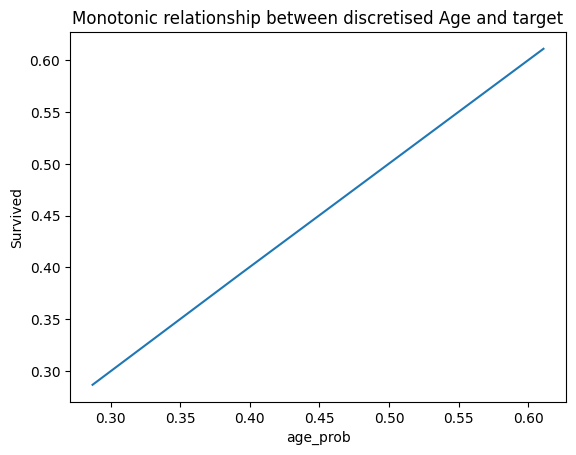

In [9]:
# relationship with target

y_train.groupby(X_train['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

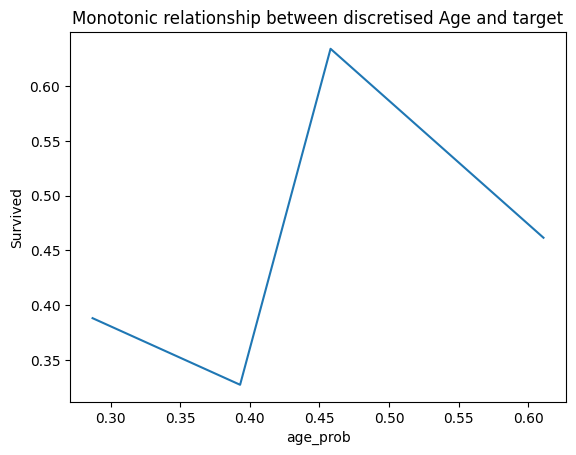

In [10]:
y_test.groupby(X_test['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<Axes: >

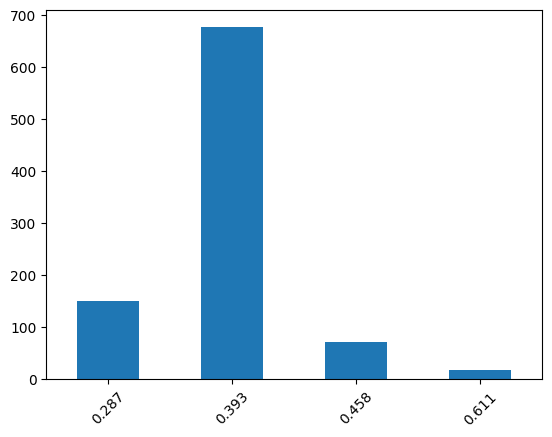

In [11]:
# number of passengers per node / bin

X_train['age_prob'].value_counts().sort_index().plot.bar(rot=45)

<Axes: >

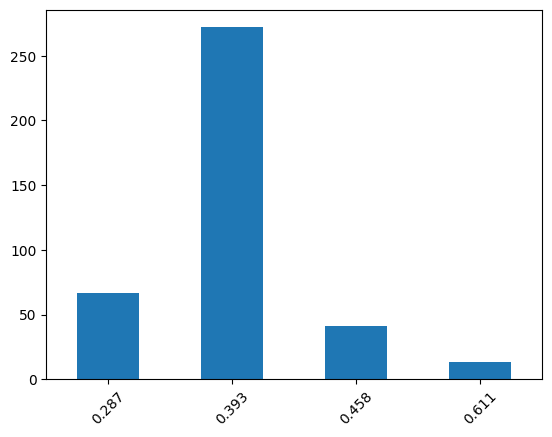

In [12]:
X_test['age_prob'].value_counts().sort_index().plot.bar(rot=45)

In [13]:
# let's see the Age limits buckets generated by the tree
# by capturing the minimum and maximum age per each probability bucket, 
# we get an idea of the bucket cut-offs

tmp = pd.concat( [X_train.groupby(['age_prob'])['age'].min(),
            X_train.groupby(['age_prob'])['age'].max()], axis=1)

tmp.columns = ["min", "max"]

tmp

,min,max
age_prob,,
0.287,16.0000,21.0
0.393,22.0000,74.0
0.458,0.1667,11.5
0.611,12.0000,15.0


In [14]:
# get inteval edges

bins = list(X_train.groupby(['age_prob'])['age'].min().sort_values().values)

bins

[0.1667, 12.0, 16.0, 22.0]

In [15]:
# expand to plus and minus inf

bins[0] = -np.inf
bins.append(np.inf)

bins

[-inf, 12.0, 16.0, 22.0, inf]

## Tree visualization

In [17]:
#pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import graphviz 
from sklearn.tree import export_graphviz

In [19]:
dot_data = export_graphviz(
    tree_model, 
    out_file=None,
    feature_names=["age"],  
    filled=True, rounded=True,  
    special_characters=True) 

graph = graphviz.Source(dot_data)

graph 

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

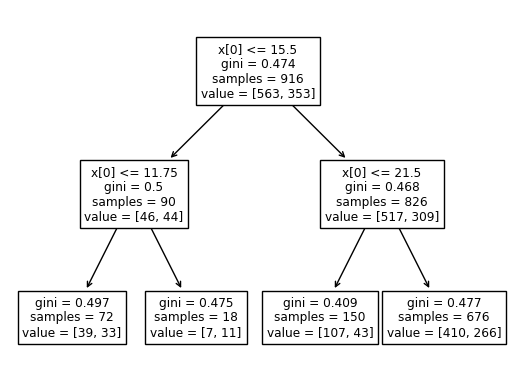

In [20]:
# alternative way of visualizing

from sklearn.tree import plot_tree

plot_tree(tree_model)
plt.show()

## Optimizing the decision tree

There are a number of parameters that we could optimize to obtain the best split using decision trees.

I will optimize the tree depth for this demonstration. But remember that we could also optimize the remaining parameters of the decision tree. 

Visit [sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to see which other parameters can be optimized.

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
parameters = {'max_depth':[1, 2, 3, 4]}

clf = GridSearchCV(
    tree_model,
    parameters,
    cv=3,
    refit=True, # so that it returns a fitted model
)

clf.fit(X_train["age"].to_frame(), y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 3, 4]})

In [23]:
# the results

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001666,4.713142e-04,0.001000,1.946680e-07,1,{'max_depth': 1},0.614379,0.593443,0.573770,0.593864,0.016581,3
1,0.001000,1.946680e-07,0.001000,1.123916e-07,2,{'max_depth': 2},0.614379,0.606557,0.590164,0.603700,0.010090,1
2,0.001667,4.718248e-04,0.001335,4.724381e-04,3,{'max_depth': 3},0.601307,0.590164,0.573770,0.588414,0.011310,4
3,0.002664,9.457850e-04,0.001336,4.747988e-04,4,{'max_depth': 4},0.611111,0.609836,0.577049,0.599332,0.015765,2


In [24]:
# the most interesting part of the resutls

pd.DataFrame(clf.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,{'max_depth': 1},0.593864,0.016581
1,{'max_depth': 2},0.603700,0.010090
2,{'max_depth': 3},0.588414,0.011310
3,{'max_depth': 4},0.599332,0.015765


In [25]:
# the best depth

clf.best_params_

{'max_depth': 2}

In [26]:
# the trained decision tree

clf.best_estimator_

DecisionTreeClassifier(max_depth=2)

In [27]:
# "discretize" the variable

X_train['age_prob'] = np.round(
    clf.best_estimator_.predict_proba(X_train['age'].to_frame())[:, 1], 3)


X_test['age_prob'] = np.round(
    clf.best_estimator_.predict_proba(X_test['age'].to_frame())[:, 1], 3)

Text(0, 0.5, 'Survived')

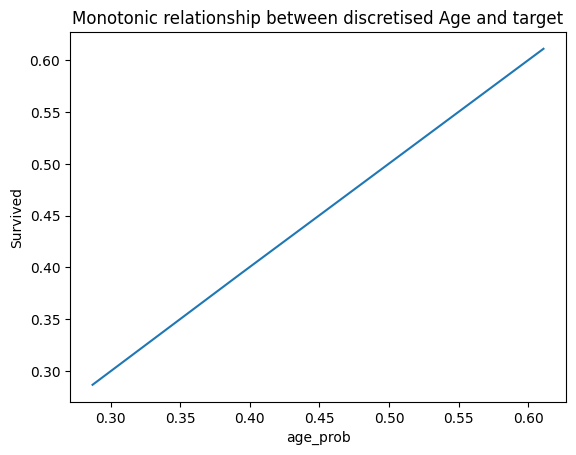

In [28]:
# relationship with target

y_train.groupby(X_train['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

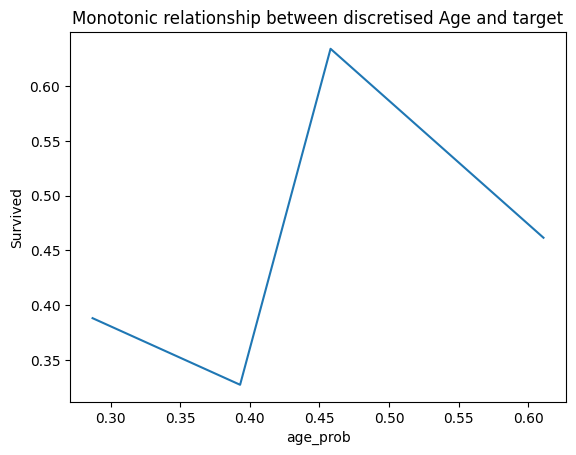

In [29]:
y_test.groupby(X_test['age_prob']).mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Now the monotonic relationship is not totally maintained in the test. Probably because there are few samples in the upper buckets:

<Axes: >

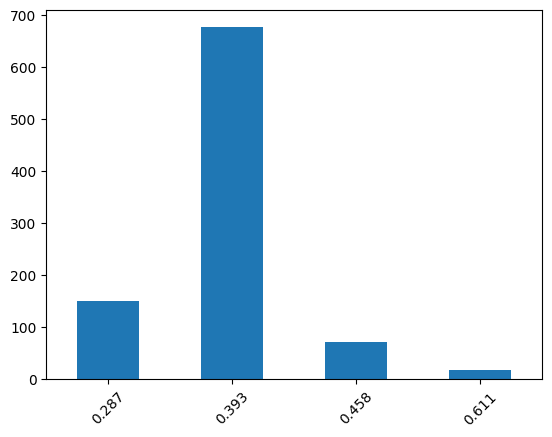

In [30]:
# number of passengers per probabilistic bucket / bin

X_train['age_prob'].value_counts().sort_index().plot.bar(rot=45)

<Axes: >

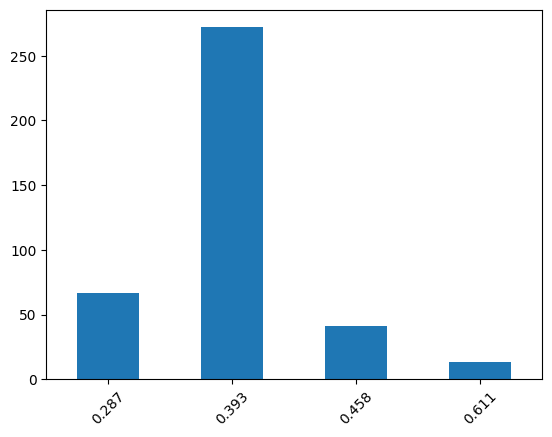

In [31]:
# number of passengers per probabilistic bucket / bin

X_test['age_prob'].value_counts().sort_index().plot.bar(rot=45)

We could try and optimise the decision tree further to see if we can keep the monotonic relationship. Or alternatively, directly test the model performance with these engineered features and see if they add any value. 

In [32]:
# get the interval limists

bins = list(X_train.groupby(['age_prob'])['age'].min().sort_values().values)

bins[0] = -np.inf
bins.append(np.inf)

bins

[-inf, 12.0, 16.0, 22.0, inf]